The Fourier Transform is a mathematical technique that decomposes an image into its frequency components, allowing for the analysis of textural patterns. We decided to add Fourier-based features to the radiomics features due to insights from the article [colocar o artigo que li]. The output is a matrix representing the intensity of the frequencies present in the image.

However, this matrix can have high dimensionality, making it difficult to handle and interpret. To simplify the analysis, we chose to work with only four significant parameters: mean, maximum, minimum, and standard deviation of the magnitude spectrum. If we used the full matrix, the resulting CSV file would exceed 1 GB, making the analysis impractical.

In [19]:
import pylidc as pl
import SimpleITK as sitk
import pandas as pd
from radiomics import featureextractor
import numpy as np
import statistics
from concurrent.futures import ThreadPoolExecutor
from pylidc.utils import consensus
from scipy.fftpack import fftn  # Import FFT 3D function

# Initialize the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Query the LIDC-IDRI dataset for scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()[:8]

# Lists to store the extracted features
features_list = []
nodule_id_counter = 1

# Function to calculate the mode or mean, depending on the case
def calculate_value(value):
    try:
        return statistics.mode(value)
    except statistics.StatisticsError:
        return np.mean(value)

def calculate_mean(value):
    return np.mean(value)

# Function to compute 3D Fourier Transform and return relevant metrics
def calculate_fourier_3d(nodule_image):
    # Apply 3D Fourier Transform (FFT)
    fourier_transformed = fftn(nodule_image)
    
    # Extract magnitude spectrum (absolute values)
    magnitude_spectrum = np.abs(fourier_transformed)
    
    # Compute some summary statistics of the magnitude spectrum
    mean_spectrum = np.mean(magnitude_spectrum)
    max_spectrum = np.max(magnitude_spectrum)
    min_spectrum = np.min(magnitude_spectrum)
    std_spectrum = np.std(magnitude_spectrum)
    
    return {
        'fourier_mean': mean_spectrum,
        'fourier_max': max_spectrum,
        'fourier_min': min_spectrum,
        'fourier_std': std_spectrum
    }

# Function to process a single scan and extract features
def process_scan(scan):
    global nodule_id_counter  # Keep track of nodule IDs across threads
    feature_data = []

    # Get the patient ID
    patient_id = scan.patient_id

    # Clusterize the annotations for the scan and retrieve all annotations
    nods = scan.cluster_annotations()

    # Use pylidc to stack DICOM slices into a 3D volume
    scan_array = scan.to_volume()

    # Handle pixel spacing depending on its type
    if isinstance(scan.pixel_spacing, (list, tuple)):
        spacing = (scan.pixel_spacing[0], scan.pixel_spacing[1], scan.slice_thickness)
    else:
        # Assuming the spacing is isotropic, if pixel_spacing is a single float
        spacing = (scan.pixel_spacing, scan.pixel_spacing, scan.slice_thickness)

    # Convert the NumPy array to a SimpleITK image for radiomics processing
    scan_image = sitk.GetImageFromArray(scan_array)
    scan_image.SetSpacing(spacing)

    # Iterating through all nodules of the patient
    for anns in nods:
        if anns:
            # Convert consensus annotations into a mask
            cmask, _, _ = pl.utils.consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])

            # Check the dimensions of the scan_array and cmask
            print(f"Scan dimensions: {scan_array.shape}, Mask dimensions: {cmask.shape}")

            # Create a nodule image initialized to zeros with the same shape as the mask
            nodule_image = np.zeros_like(cmask, dtype=scan_array.dtype)

            # Fill the nodule_image based on the mask and corresponding region in scan_array
            if cmask.shape[0] <= scan_array.shape[0]:  # Check depth
                nodule_image[cmask > 0] = scan_array[
                    np.where(cmask > 0)[0],
                    np.where(cmask > 0)[1],
                    np.where(cmask > 0)[2]
                ]

            # Convert the new nodule image to a SimpleITK image
            nodule_image_sitk = sitk.GetImageFromArray(nodule_image)
            nodule_image_sitk.SetSpacing(spacing)

            # Convert the mask to a SimpleITK image
            mask_image = sitk.GetImageFromArray(cmask.astype(np.uint8))
            mask_image.SetSpacing(spacing)

            # Extract radiomic features using PyRadiomics
            features = extractor.execute(nodule_image_sitk, mask_image, label=1)

            # Add the patient ID and a unique ID for the nodule
            features['Patient_ID'] = patient_id
            features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
            nodule_id_counter += 1

            # Calculate the additional annotation features for this nodule
            subtlety_value = calculate_value([ann.subtlety for ann in anns])
            internalStructure_value = calculate_value([ann.internalStructure for ann in anns])
            calcification_value = calculate_value([ann.calcification for ann in anns])
            sphericity_value = calculate_value([ann.sphericity for ann in anns])
            margin_value = calculate_value([ann.margin for ann in anns])
            lobulation_value = calculate_value([ann.lobulation for ann in anns])
            spiculation_value = calculate_value([ann.spiculation for ann in anns])
            texture_value = calculate_value([ann.texture for ann in anns])
            malignancy_mode = calculate_value([ann.malignancy for ann in anns])
            malignancy_mean = calculate_mean([ann.malignancy for ann in anns])

            # Append these calculated values to the feature dictionary
            features.update({
                'subtlety': subtlety_value,
                'internalStructure': internalStructure_value,
                'calcification': calcification_value,
                'sphericity': sphericity_value,
                'margin': margin_value,
                'lobulation': lobulation_value,
                'spiculation': spiculation_value,
                'texture': texture_value,
                'malignancy_mode': malignancy_mode,
                'malignancy_mean': malignancy_mean
            })

            # Calculate Fourier Transform 3D features
            fourier_features = calculate_fourier_3d(nodule_image)
            features.update(fourier_features)

            # Add the features to the feature data
            feature_data.append(features)
    
    return feature_data

# Multithreaded execution
with ThreadPoolExecutor(max_workers=8) as executor:
    results = executor.map(process_scan, scans_with_annotations)

# Collect results from all workers
for result in results:
    features_list.extend(result)

# Create a DataFrame to store the features
features_df = pd.DataFrame(features_list)

# Reorder columns to move 'malignancy_mode' before 'malignancy_mean'
columns = [col for col in features_df.columns if col not in ['malignancy_mean', 'malignancy_mode']]
columns.extend(['malignancy_mode', 'malignancy_mean'])  # Add them with 'malignancy_mode' first

# Reorganize the DataFrame
features_df = features_df[columns]

# Save the features to a CSV file
features_df.to_csv('radiomic_features_pylidc_and_fourier.csv', index=False)


Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.
Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 113), Mask dimensions: (67, 62, 5)
Scan dimensions: (512, 512, 112), Mask dimensions: (71, 70, 8)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 125), Mask dimensions: (57, 57, 4)
Scan dimensions: (512, 512, 125), Mask dimensions: (54, 53, 3)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 87), Mask dimensions: (74, 84, 6)
Scan dimensions: (512, 512, 150), Mask dimensions: (61, 48, 2)
Scan dimensions: (512, 512, 127), Mask dimensions: (55, 54, 3)
Scan dimensions: (512, 512, 87), Mask dimensions: (80, 67, 6)
Scan dimensions: (512, 512, 127), Mask dimensions: (51, 53, 3)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 87), Mask dimensions: (48, 47, 2)
Scan dimensions: (512, 512, 127), Mask dimensions: (61, 55, 1)
Scan dimensions: (512, 512, 87), Mask dimensions: (90, 80, 8)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 127), Mask dimensions: (80, 103, 6)
Scan dimensions: (512, 512, 136), Mask dimensions: (66, 59, 9)
Scan dimensions: (512, 512, 136), Mask dimensions: (46, 47, 1)
Scan dimensions: (512, 512, 127), Mask dimensions: (58, 54, 1)
Scan dimensions: (512, 512, 136), Mask dimensions: (69, 83, 11)
Scan dimensions: (512, 512, 127), Mask dimensions: (56, 55, 2)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 153), Mask dimensions: (49, 47, 1)
Scan dimensions: (512, 512, 153), Mask dimensions: (51, 53, 2)
Scan dimensions: (512, 512, 153), Mask dimensions: (49, 48, 2)
Scan dimensions: (512, 512, 153), Mask dimensions: (54, 52, 3)
Scan dimensions: (512, 512, 153), Mask dimensions: (56, 53, 3)
Scan dimensions: (512, 512, 153), Mask dimensions: (51, 52, 3)
Scan dimensions: (512, 512, 153), Mask dimensions: (72, 62, 6)
Scan dimensions: (512, 512, 153), Mask dimensions: (53, 51, 2)


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Scan dimensions: (512, 512, 153), Mask dimensions: (50, 48, 2)


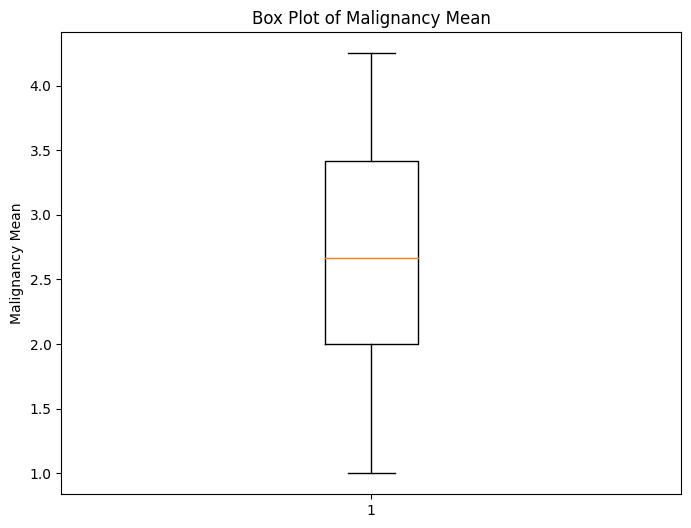

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Leia o arquivo CSV gerado
features_df = pd.read_csv('radiomic_features_pylidc_and_fourier.csv')

# Visualize as primeiras linhas para verificar se as colunas estão corretas
#print(features_df.head())

# Selecione a coluna de malignidade (malignancy_mode ou malignancy_mean)
malignancy_data = features_df['malignancy_mean']

# Crie o boxplot usando apenas Matplotlib
plt.figure(figsize=(8, 6))
plt.boxplot(malignancy_data)

# Adicione título e rótulos
plt.title('Box Plot of Malignancy Mean')
plt.ylabel('Malignancy Mean')

# Mostre o gráfico
plt.show()



In [22]:
non_numeric_columns = features_df.select_dtypes(exclude=['number']).columns

# Count the number of numeric and non-numeric columns
num_non_numeric_columns = len(non_numeric_columns)
num_numeric_columns = features_df.shape[1] - num_non_numeric_columns

print(f"Número de colunas numéricas: {num_numeric_columns}")
print(f"Número de colunas não numéricas: {num_non_numeric_columns}")

Número de colunas numéricas: 126
Número de colunas não numéricas: 19


We are now going to remove non-numeric features from the dataset, as they do not contribute to predictive modeling in the context of predicting malignancy.

In [25]:
import pandas as pd

csv_path = 'radiomic_features_pylidc_and_fourier.csv' 
features_df = pd.read_csv(csv_path)

# Remover colunas não numéricas usando drop
features_df.drop(columns=non_numeric_columns, inplace=True)

features_df.to_csv(csv_path, index=False)


# Just to check if the drop was successful 
non_numeric_columns = features_df.select_dtypes(exclude=['number']).columns

num_non_numeric_columns = len(non_numeric_columns)
num_numeric_columns = features_df.shape[1] - num_non_numeric_columns

print(f"Número de colunas numéricas: {num_numeric_columns}")
print(f"Número de colunas não numéricas: {num_non_numeric_columns}")


Número de colunas numéricas: 126
Número de colunas não numéricas: 0
